In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

import joblib

In [4]:
# Download cleaned file
url = 'https://drive.usercontent.google.com/download?id=1F5zbAZrQumN6VlJErmu_yP8N0HgL6306&export=download&authuser=0&confirm=t'
df = pd.read_csv(url, on_bad_lines='skip')

In [5]:
# Balance the dataset to be 50/50 for status 0 and 1
status_1_sample = df[df['status']==1].sample(100_000, random_state=1)
status_0_sample = df[df['status']==0].sample(100_000, random_state=1)

full = pd.concat([status_0_sample, status_1_sample])
full

,crimeTheft,crimeViolence,crimeSexual,crimeDamage,crimeChild,crimeFraud,crimeWeapon,crimeViolation,crimeKidnap,weaponHuman,weaponGun,weaponMachine,weaponNone,weaponVerbal,weaponChemical,sitePublicArea,siteStoreRestaurant,sitePublicTransport,sitePrivateTransport,sitePrivateHome,siteAthletic,siteSchoolHospital,sitePrivateProperty,siteOnline,reportDelay,reportTimely,relationship,lat,lon,crimeCountTotal,crimeCountSixMonths,crimeDensity,crimeDensitySixMonths,arrestRatio,status,crimeDensityCategory,ami_catego,victimSex_f,victimSex_m,victimSex_x,victimDescentCategory_asian,victimDescentCategory_black,victimDescentCategory_hispanic,victimDescentCategory_native,victimDescentCategory_other,victimDescentCategory_pacific islander,victimDescentCategory_unknown,victimDescentCategory_white,victimAge_adult,victimAge_minor,victimAge_senior,victimAge_unknown
2593147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,33.9531,-118.2363,2012,61,2.000000,0.060636,0.245030,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
670421,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,34.2143,-118.5534,3876,139,2.829197,0.101460,0.325593,0,1,2,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0
3007157,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,33.7324,-118.2879,5699,261,3.653205,0.167308,0.337077,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0
720612,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,34.2139,-118.5754,1815,72,1.369811,0.054340,0.308540,0,0,2,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2845391,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,33.9925,-118.4186,2855,101,1.575607,0.055740,0.212960,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2488537,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,33.9556,-118.2664,5011,213,4.015224,0.170673,0.209938,1,2,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1632876,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,34.0593,-118.2719,2818,91,2.602031,0.084026,0.309084,1,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3075275,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,107,0,0,33.9454,-118.3750,22140,795,220.000000,12.000000,0.135772,1,2,-1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2711965,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-1,1,0,34.0406,-118.4275,4756,177,3.443881,0.128168,0.175988,1,1,2,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


In [6]:
# Split data into X and y (features and target variable)
X = full.drop(columns=['status'])
y = full['status']

# Split into train/test sets
# 'stratify' makes sure that the ratio of 1s to 0s is maintained in the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y, random_state=1)

In [8]:
# Scale data with StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled = pd.DataFrame(scaler.transform(X_train_scaled), columns=scaler.get_feature_names_out())
X_test_scaled = pd.DataFrame(scaler.transform(X_test_scaled), columns=scaler.get_feature_names_out())

# Save the scaler
joblib.dump(scaler, 'models/StandardScaler.pkl')

['models/StandardScaler.pkl']

Index(['relationship', 'crimeDensitySixMonths', 'lat', 'crimeCountSixMonths',
       'lon', 'crimeTheft', 'arrestRatio', 'crimeCountTotal', 'crimeDensity',
       'reportDelay', 'crimeViolence', 'weaponHuman', 'ami_catego',
       'sitePrivateHome', 'crimeWeapon'],
      dtype='object')


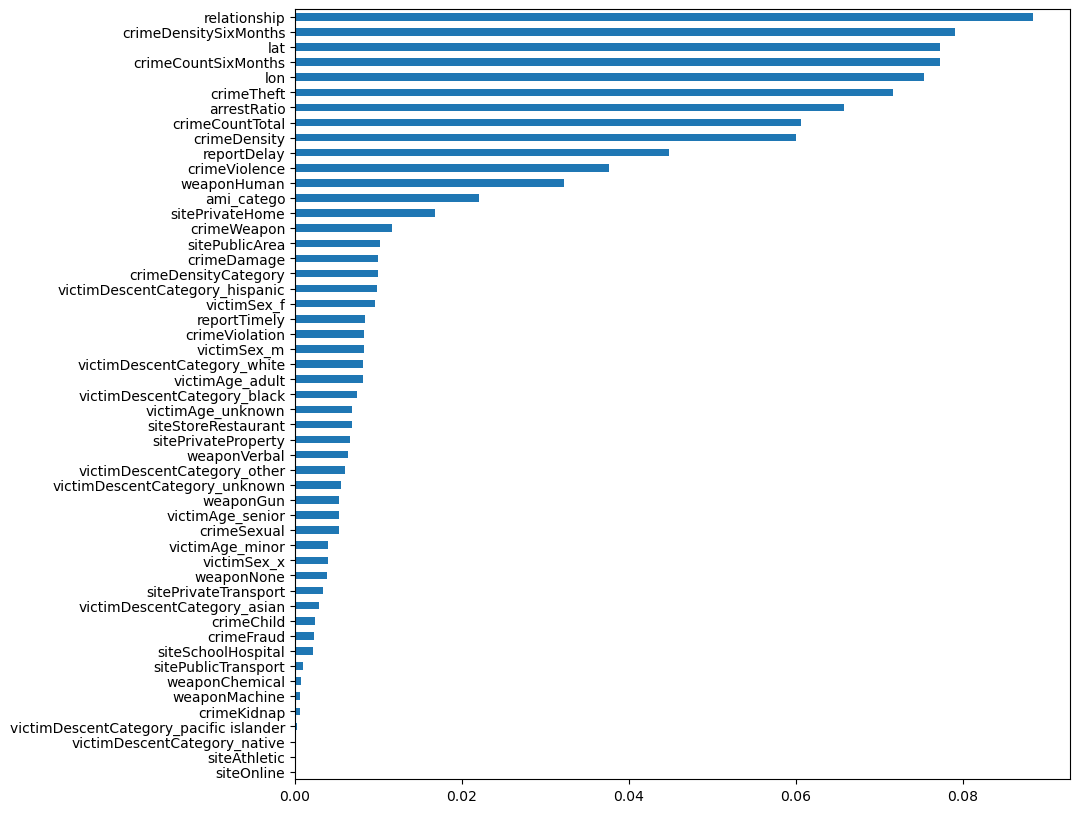

In [6]:
# Identifying best features
model = RandomForestClassifier(n_estimators=100, random_state=1)
model.fit(X_train_scaled, y_train)

importances = model.feature_importances_
feature_names = X.columns
feature_importance = pd.Series(importances, index=feature_names)

# Print top 15 features by importance
print(feature_importance.sort_values(ascending=False).index[:15])

# Plot all feature importances
feature_importance.sort_values(ascending=True).plot(kind='barh', figsize=(10, 10))
plt.show()

### Observations:
- Data about the victim (age, sex, descent) all scored quite low
- Crimes involving a weapon, and crimes where the 'weapon' was the human body both scored somewhat well. Aside from that, the type of weapons involved was not considered important
- Most types of site scored low, except private homes
- The victim-suspect relationship scored very high
- Latitude and longitude both scored very high
- Most statistical data about crime in the local area scored very high

In [9]:
# Reduce dataframe to just these columns (open to experimentation)
reduced_cols = ['relationship', 'crimeDensitySixMonths', 'lat', 'crimeCountSixMonths',
       'lon', 'crimeTheft', 'arrestRatio', 'crimeCountTotal', 'crimeDensity',
       'reportDelay', 'crimeViolence', 'weaponHuman', 'ami_catego',
       'sitePrivateHome', 'crimeWeapon']

X_train_scaled = X_train_scaled[reduced_cols]
X_test_scaled = X_test_scaled[reduced_cols]

## Trying multiple models
### Using GridSearchCV to try many hyperparameters
- n_jobs is for speeding up training by parallelizing jobs across multiple CPU cores (-1 means all available cores)

In [8]:
# Finding optimal RandomForestClassifier hyperparameters
model = RandomForestClassifier()
param_grid = {
    'n_estimators': [32, 64, 128],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],               
    'max_features': [.33, .66, None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced'],
    'n_jobs': [-1],
    'random_state': [1]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print(f'Best Score: {grid_search.best_score_}')
print(f'Best Params: {grid_search.best_params_}')

Best Score: 0.7515499665652734
Best Params: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 0.33, 'min_samples_split': 5, 'n_estimators': 32, 'n_jobs': -1, 'random_state': 1}


In [9]:
# Finding optimal AdaBoostClassifier hyperparameters
model = AdaBoostClassifier()
param_grid = {
    'n_estimators': [16, 32, 64, 128],
    'learning_rate': [0.1, 1],
    'algorithm': ['SAMME'],
    'random_state': [1]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print(f'Best Score: {grid_search.best_score_}')
print(f'Best Params: {grid_search.best_params_}')

Best Score: 0.74325
Best Params: {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 128, 'random_state': 1}


In [10]:
# Finding optimal ExtraTreesClassifier hyperparameters
model = ExtraTreesClassifier()
param_grid = {
    'n_estimators': [32, 64, 128],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],            
    'max_features': [.33, .66, None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced'],
    'n_jobs': [-1],
    'random_state': [1]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print(f'Best Score: {grid_search.best_score_}')
print(f'Best Params: {grid_search.best_params_}')

Best Score: 0.7478999803103673
Best Params: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 0.66, 'min_samples_split': 2, 'n_estimators': 128, 'n_jobs': -1, 'random_state': 1}


In [11]:
# Finding optimal XGBClassifier hyperparameters
model = XGBClassifier()
param_grid = {
    'n_estimators': [32, 64, 128],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'reg_lambda': [1, 10],
    'reg_alpha': [0, 0.1],  
    'tree_method': ['exact', 'approx', 'hist'],
    'n_jobs': [8],
    'random_state': [1]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print(f'Best Score: {grid_search.best_score_}')
print(f'Best Params: {grid_search.best_params_}')

Best Score: 0.7524249999999999
Best Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 64, 'n_jobs': 8, 'random_state': 1, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8, 'tree_method': 'approx'}


In [12]:
# Try SVC with different kernels
# SVC is very slow to fit, so we will only test its kernel options.
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    model = SVC(kernel=kernel, random_state=1)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    print(f'Kernel: {kernel} - Accuracy: {accuracy_score(y_test, preds)}')

Kernel: linear - Accuracy: 0.7170125
Kernel: poly - Accuracy: 0.747175
Kernel: rbf - Accuracy: 0.7507375
Kernel: sigmoid - Accuracy: 0.64584375


In [10]:
# Instantiating each model with the best hyperparameters from GridSearchCV
rfc = RandomForestClassifier(
    bootstrap = True,
    class_weight = 'balanced',
    criterion = 'gini',
    max_depth = 10,
    max_features = 0.33,
    min_samples_split = 5,
    n_estimators = 32,
    n_jobs = -1,
    random_state = 1)

svc = SVC(
    kernel='rbf',
    random_state=1,
    )

xgbc = XGBClassifier(
    colsample_bytree = 1.0,
    gamma = 0,
    learning_rate = 0.1,
    max_depth = 5,
    n_estimators = 64,
    n_jobs = 8,
    random_state = 1,
    reg_alpha = 0.1,
    reg_lambda = 1,
    subsample = 0.8,
    tree_method = 'approx'
)

adac = AdaBoostClassifier(
    algorithm = 'SAMME',
    learning_rate = 1,
    n_estimators = 128,
    random_state = 1)

etc = ExtraTreesClassifier(
    bootstrap = True,
    class_weight = None,
    criterion = 'gini',
    max_depth = 10,
    max_features = 0.66,
    min_samples_split = 2,
    n_estimators = 128,
    n_jobs = -1,
    random_state = 1
)

# Fitting all models and collecting their predictions
all_preds = []
for model in [rfc, svc, xgbc, adac, etc]:
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    all_preds.append(preds)
    print(f'{model.__class__} fit')

<class 'sklearn.ensemble._forest.RandomForestClassifier'> fit
<class 'sklearn.svm._classes.SVC'> fit
<class 'xgboost.sklearn.XGBClassifier'> fit
<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> fit
<class 'sklearn.ensemble._forest.ExtraTreesClassifier'> fit


In [14]:
# Saving off model objects so they can be quickly loaded and used later without having to re-fit
joblib.dump(rfc, 'models/RandomForestClassifier.pkl')
joblib.dump(svc, 'models/SupportVectorClassifier.pkl')
joblib.dump(xgbc, 'models/XGBoostClassifier.pkl')
joblib.dump(adac, 'models/AdaBoostClassifier.pkl')
joblib.dump(etc, 'models/ExtraTreesClassifier.pkl')

['models/ExtraTreesClassifier.pkl']

In [11]:
# An ensembling method is to have multiple models 'vote' with their predictions.
# A single model might predict a 0, but if the majority of models predict a 1, then the winning prediction is a 1.
# In some cases this can increase performance metrics, by having the strengths of multiple models compensate for the weaknesses of any individual model.

# Average all 5 models' predictions
mean_preds = np.mean(all_preds, axis=0)

# Create a dictionary to save scores
threshold_dict = {}

# 3 out of 5 is the majority, but we're testing to see what accuracy we'd get if we choose predictions based on other thresholds (1 out of 5, 2 out of 5, etc.)
for i in range(1, 6):
    threshold_dict[i] = accuracy_score(y_test, np.where(mean_preds >= i/5, 1, 0))

# Show the best threshold
best_threshold = max(threshold_dict, key=threshold_dict.get)
print(best_threshold)
print(accuracy_score(y_test, np.where(mean_preds >= best_threshold/5, 1, 0)))

3
0.753125


<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.svm._classes.SVC'>
<class 'xgboost.sklearn.XGBClassifier'>
<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>


<Axes: xlabel='Model', ylabel='Accuracy'>

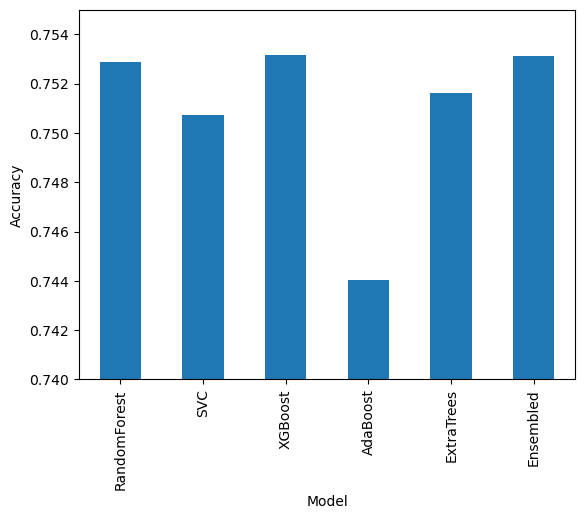

In [12]:
# Finally, we see if ensembling resulted in better accuracy than any individual model
score_list = []
for model in [rfc, svc, xgbc, adac, etc]:
    preds = model.predict(X_test_scaled)
    score_list.append(accuracy_score(preds, y_test))
    print(f'{model.__class__}')
score_list.append(accuracy_score(y_test, np.where(mean_preds >= best_threshold/5, 1, 0)))

# Plot the results
final_scores = pd.DataFrame(zip(['RandomForest', 'SVC', 'XGBoost', 'AdaBoost', 'ExtraTrees', 'Ensembled'], score_list))
final_scores.columns = ['Model', 'Accuracy']
final_scores.set_index('Model', inplace=True)
final_scores.plot(kind='bar', ylim=(.74, .755), legend=None, ylabel='Accuracy')

In [13]:
final_scores.sort_values('Accuracy')

,Accuracy
Model,
AdaBoost,0.744031
SVC,0.750737
ExtraTrees,0.751631
RandomForest,0.752869
Ensembled,0.753125
XGBoost,0.753144


Ensembling in this case did not improve anything. It tends to work better when there are greater differences between each model, like being trained on different features.

In [14]:
# Finally, we test our models against the entire dataset (all 3,089,923 crimes)
X_entire = df.drop(columns=['status'])
y_entire = df['status']

scaler = joblib.load('models/StandardScaler.pkl')

X_entire_scaled = pd.DataFrame(scaler.transform(X_entire), columns=scaler.get_feature_names_out())
X_entire_scaled = X_entire_scaled[reduced_cols]

In [15]:
# XGBoost
xgbc = joblib.load('models/XGBoostClassifier.pkl')

preds_entire = xgbc.predict(X_entire_scaled)
print(accuracy_score(y_entire, preds_entire))
print(classification_report(y_entire, preds_entire))

0.7628002380641847
              precision    recall  f1-score   support

           0       0.91      0.77      0.83   2396843
           1       0.48      0.74      0.58    693080

    accuracy                           0.76   3089923
   macro avg       0.70      0.75      0.71   3089923
weighted avg       0.81      0.76      0.78   3089923



In [16]:
# RandomForest
rfc = joblib.load('models/RandomForestClassifier.pkl')

preds_entire = rfc.predict(X_entire_scaled)
print(accuracy_score(y_entire, preds_entire))
print(classification_report(y_entire, preds_entire))

0.7623714247895498
              precision    recall  f1-score   support

           0       0.91      0.77      0.83   2396843
           1       0.48      0.74      0.58    693080

    accuracy                           0.76   3089923
   macro avg       0.70      0.75      0.71   3089923
weighted avg       0.81      0.76      0.78   3089923



In [17]:
# ExtraTrees
etc = joblib.load('models/ExtraTreesClassifier.pkl')

preds_entire = etc.predict(X_entire_scaled)
print(accuracy_score(y_entire, preds_entire))
print(classification_report(y_entire, preds_entire))

0.7658546831102264
              precision    recall  f1-score   support

           0       0.91      0.78      0.84   2396843
           1       0.49      0.73      0.58    693080

    accuracy                           0.77   3089923
   macro avg       0.70      0.75      0.71   3089923
weighted avg       0.81      0.77      0.78   3089923



In [18]:
# AdaBoost
adac = joblib.load('models/AdaBoostClassifier.pkl')

preds_entire = adac.predict(X_entire_scaled)
print(accuracy_score(y_entire, preds_entire))
print(classification_report(y_entire, preds_entire))

0.7613733416657955
              precision    recall  f1-score   support

           0       0.90      0.78      0.83   2396843
           1       0.48      0.71      0.57    693080

    accuracy                           0.76   3089923
   macro avg       0.69      0.74      0.70   3089923
weighted avg       0.81      0.76      0.78   3089923



In [19]:
# SVC (took 81 minutes to predict)
svc = joblib.load('models/SupportVectorClassifier.pkl')

preds_entire = svc.predict(X_entire_scaled)
print(accuracy_score(y_entire, preds_entire))
print(classification_report(y_entire, preds_entire))

0.7628730554127077
              precision    recall  f1-score   support

           0       0.91      0.77      0.83   2396843
           1       0.48      0.73      0.58    693080

    accuracy                           0.76   3089923
   macro avg       0.69      0.75      0.71   3089923
weighted avg       0.81      0.76      0.78   3089923

